# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Indest Data

In [54]:
df = pd.read_csv("Frozen_Dessert_Production.csv",
                index_col='DATE',
                 parse_dates=True
                )
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [55]:
df.shape

(573, 1)

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [56]:
df["Production"] = df["IPN31152N"]

In [57]:
df.drop(columns="IPN31152N", inplace=True)

In [58]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [60]:
df.duplicated().value_counts()

False    573
dtype: int64

In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Production,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


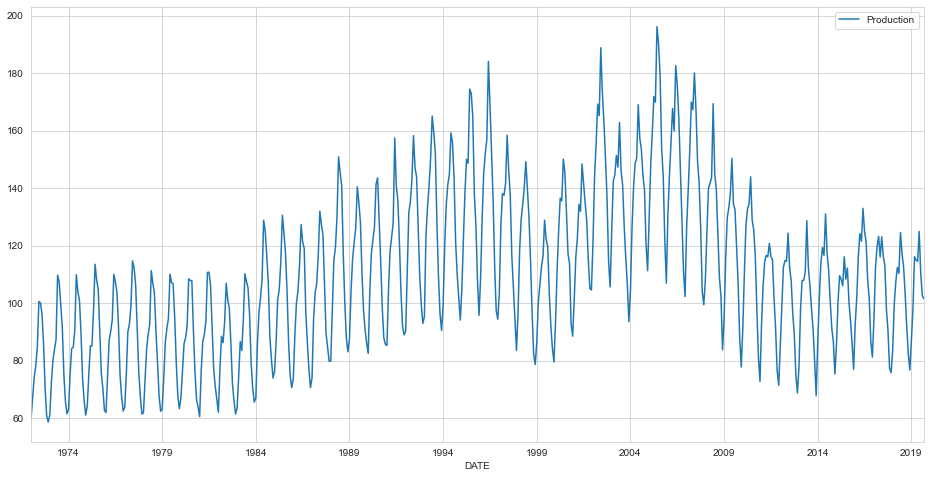

In [62]:
df.plot(figsize=(16,8));

In [63]:
df["month"] = df.index.month

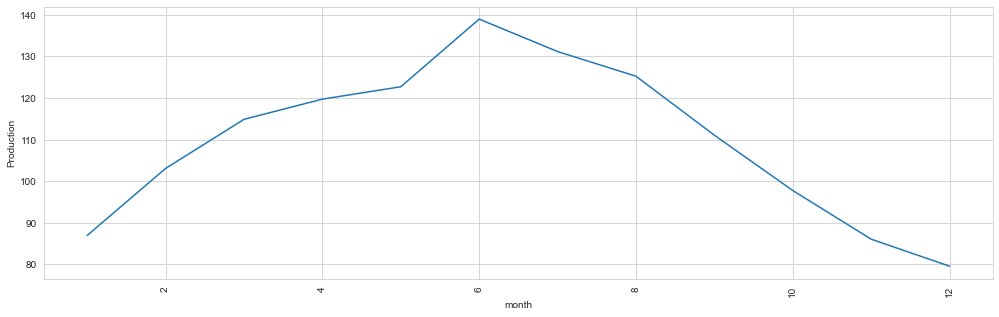

In [64]:
plt.figure(figsize=(17,5))
sns.lineplot(x="month", y="Production", data=df, ci=None)
plt.xticks(rotation=90);

In [65]:
df.drop(columns="month", inplace=True)

## Preprocessing of Data

### Train Test Split

In [66]:
test_ind = len(df) - 18 #(18 months) #every period is about 12 months

In [67]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [68]:
train.shape

(555, 1)

In [69]:
test.shape

(18, 1)

### Scaling

In [70]:
from sklearn.preprocessing import MinMaxScaler

In [71]:
scaler = MinMaxScaler()

In [72]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [73]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [74]:
length = 12 
batch_size = 1 
generator = TimeseriesGenerator(data = train_scaled,
                                targets = train_scaled,
                                length = length,
                                batch_size = batch_size)

In [75]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [76]:
X, y = generator[0]

In [77]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [79]:
n_features = 1

In [80]:
model = Sequential()
model.add(LSTM(150, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [82]:
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [84]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=batch_size)

In [85]:
model.fit_generator(generator, epochs = 20,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 6s 8ms/step - loss: 0.0183 - val_loss: 0.0014
Epoch 2/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 3/20
543/543 [==============================] - 9s 16ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 4/20
543/543 [==============================] - 6s 11ms/step - loss: 0.0041 - val_loss: 0.0020


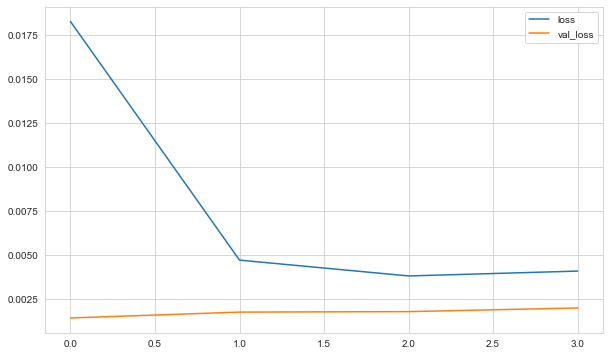

In [86]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

#### Evaluate on Test Data

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [88]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [89]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [90]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.8346921545521357 
 mae: 0.030027470213633636 
 mse: 0.0015896700441852647 
 rmse: 0.03987066646276764


#### Inverse Transformations and Comparing

In [91]:
true_predictions = scaler.inverse_transform(test_predictions)

In [92]:
test['Predictions'] = true_predictions

In [93]:
test

,Production,Predictions
DATE,,
2018-04-01,112.431,114.182
2018-05-01,110.354,119.578
2018-06-01,124.584,122.158
2018-07-01,117.222,119.677
2018-08-01,112.678,112.419
2018-09-01,103.312,101.003
2018-10-01,92.132,89.897
2018-11-01,82.435,82.525
2018-12-01,76.761,81.965


#### Calculation R2 Score and Error Metrics

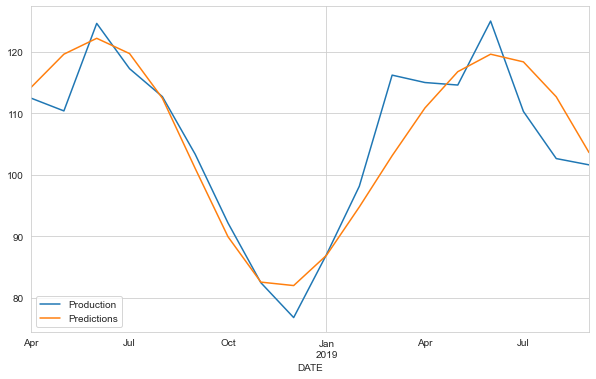

In [94]:
test.plot();

In [95]:
eval_metrics(test.Production, test.Predictions)

r2_score: 0.834692154552136 
 mae: 4.129194536210594 
 mse: 30.060776093761692 
 rmse: 5.482770840894382


### with "relu" activation function

In [96]:
model2 = Sequential()
model2.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [97]:
model2.fit_generator(generator, epochs = 20,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 6s 7ms/step - loss: 0.0262 - val_loss: 0.0035
Epoch 2/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 3/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 4/20
543/543 [==============================] - 5s 8ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 5/20
543/543 [==============================] - 5s 10ms/step - loss: 0.0035 - val_loss: 0.0067
Epoch 6/20
543/543 [==============================] - 5s 9ms/step - loss: 0.0038 - val_loss: 0.0018


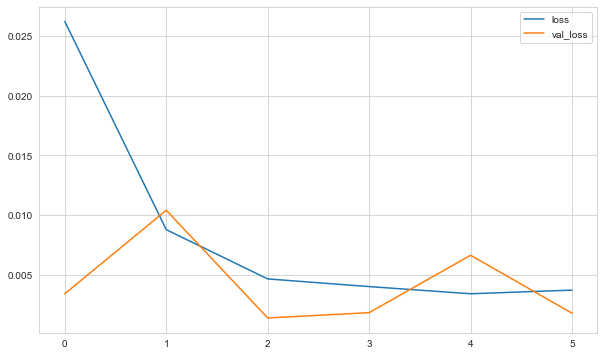

In [98]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot();

#### Evaluate on Test Data

In [99]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model2.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [100]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.7980242723644103 
 mae: 0.033748306436345916 
 mse: 0.0019422838825643109 
 rmse: 0.04407134990630887


#### Inverse Transformations and Comparing

In [101]:
true_predictions = scaler.inverse_transform(test_predictions)

In [102]:
test['Predictions'] = true_predictions
test

,Production,Predictions
DATE,,
2018-04-01,112.431,112.988
2018-05-01,110.354,117.093
2018-06-01,124.584,119.854
2018-07-01,117.222,118.636
2018-08-01,112.678,111.672
2018-09-01,103.312,100.111
2018-10-01,92.132,88.913
2018-11-01,82.435,79.963
2018-12-01,76.761,77.844


#### Calculation R2 Score and Error Metrics

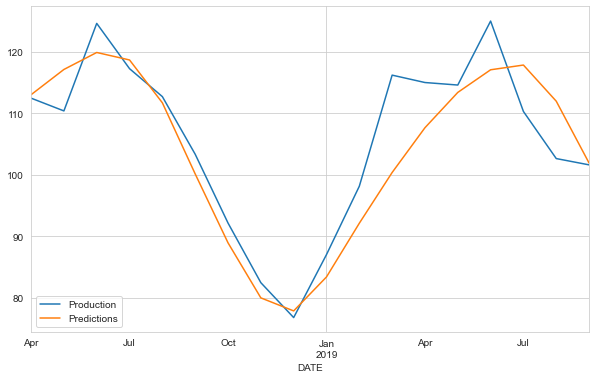

In [103]:
test.plot();

In [104]:
eval_metrics(test.Production, test.Predictions)

r2_score: 0.7980242723644102 
 mae: 4.640861236457032 
 mse: 36.72872941014132 
 rmse: 6.060423203881171


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [105]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [106]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [107]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 5s 7ms/step - loss: 0.0276
Epoch 2/15
561/561 [==============================] - 4s 6ms/step - loss: 0.0125
Epoch 3/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0044
Epoch 4/15
561/561 [==============================] - 4s 6ms/step - loss: 0.0041
Epoch 5/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0038
Epoch 6/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0036
Epoch 7/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0034
Epoch 8/15
561/561 [==============================] - 4s 8ms/step - loss: 0.0033A: 0s - lo
Epoch 9/15
561/561 [==============================] - 3s 6ms/step - loss: 0.0031
Epoch 10/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0032
Epoch 11/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0032
Epoch 12/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0030
Epoch 13/15
561

In [108]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [110]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [109]:
forecast = scaler.inverse_transform(forecast)

In [111]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [112]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

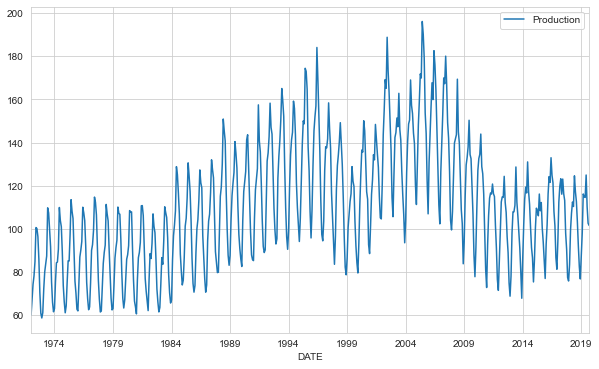

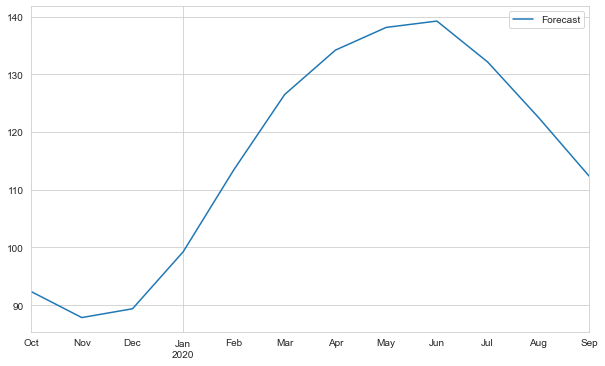

In [113]:
df.plot()
forecast_df.plot();

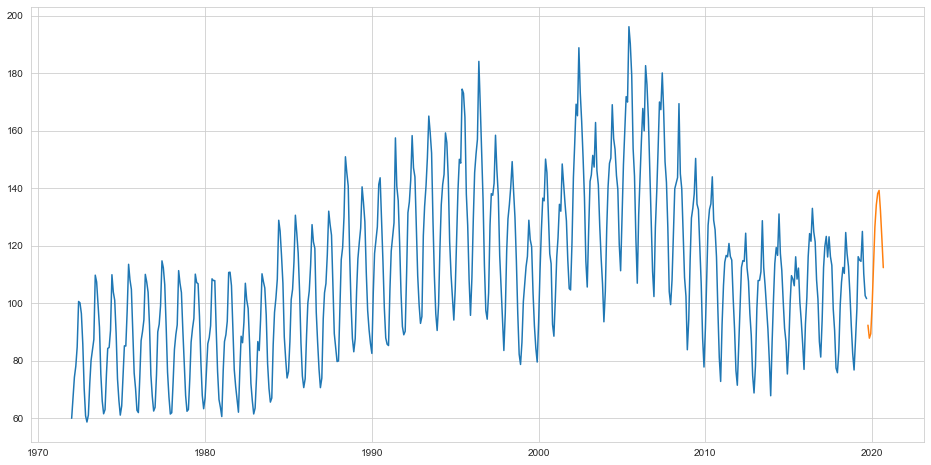

In [115]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast']);

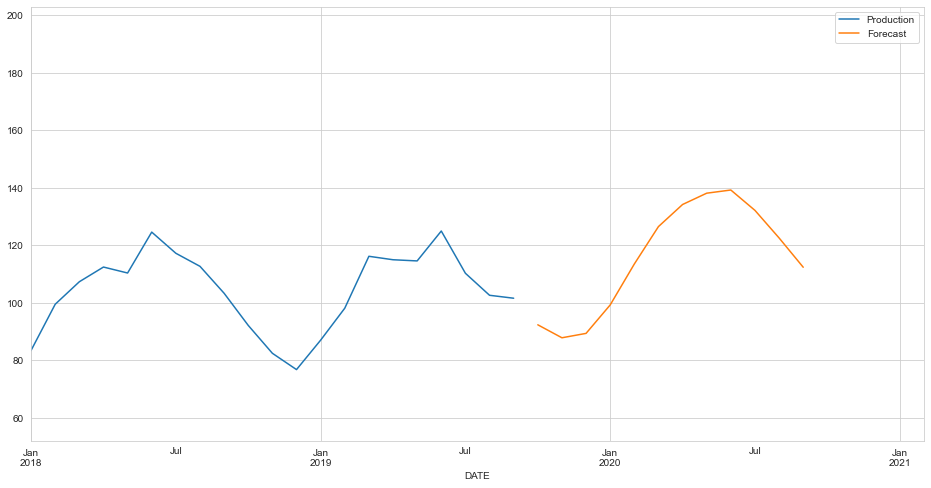

In [117]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-02-01');